## Introduction and transition from the slides

Recall that Alice wants to help Bob solve his supply chain problem. Bob has six customer orders, all have a certain size (number of chips) and promise Bob a certain revenue. Bob's machines can produce seven wafer chips, so he has to decide, which orders to fulfill and which to postpone to another day. Of course, he wants to maximize his profit under the contraint of not overstepping the capacity of his machines. See the illustration

<img src="fab_problem.png" width="600" />

### Exercise 1 
Try different configurations for choosing the customer orders. Try to maximize the total revenue while not violating the constraint.

# Knapsack Problem

In optimization theory, Bob's task is called the *knapsack problem*. The customer orders are called *items*, their size is called *weight* and their revenue *value*. Bob's fab is called the *knapsack*. Now the task consists of packing items into the knapsack such that 

- their total weight does not exceed the capacity and
- their total value is maximized.

The next thing to do is to set up a mathematical formulation for our optimization task, expressing it in terms of concrete formulae.

To this end, we set up binary variables $x_1,x_2,...,x_6$, where $x_i=1$ indicates that item $i$ goes into the knapsack and $x_i=0$ indicates that it does not. As an example, the bitstring $(1, 0, 0, 1, 1, 0)$ encodes packing the first, fourth and fifth item into the knapsack.

Now, the weights and values are introduced into our model by assigning positive integers $v_i$ (value of item $i$) and $w_i$ (weight of item $i$) to each item $i$. The capacity of the knapsack is another positive integer $C$. Now we are ready to formulate our objective terms of formulae:

$\max_{(x_1,...,x_6) \in \{0,1\}^6} \sum_{i \in \{1,...,6\}} x_i \cdot v_i$

such that $\sum_{i \in \{0,1\}^6}w_i \cdot x_i \leq C$.


# From Knapsack to QUBO to Hamiltonian

One very common way to apply quantum algorithms to an optimization task is to construct a *Hamiltonian*, whose lowest energy eigenstate corresponds to the solution to our optimization task. The encoding into a Hamiltonian enables us to implement an algorithm for our problem on the quantum mechanical system living inside our quantum computer.

## QUBO problems

A standard approach towards a Hamiltonian encoding is to formulate the optimization task as a *QUBO* problem, where QUBO stands for **Q**uadratic **U**nconstrained **B**inary **O**ptimization.

Recall that our mathematical formulation of the knapsack problem is

$\max_{(x_1,...,x_6) \in \{0,1\}^6} \sum_{i \in \{1,...,6\}} x_i \cdot v_i$

such that $\sum_{i \in \{0,1\}^6}w_i \cdot x_i \leq C$.

This formulation is already *binary*, i.e. it uses binary variables and *quadratic*, i.e. there are no terms of higher powers than $2$. However, it is not yet *unconstrained*, as there is the constraint not to overstep the capacity of the knapsack.

In order to get rid of this constraint, we want to add it to the goal function as a *penalty term*. A penalty term is designed such that it adds a large penalty in case the constraint is violated, thus making such configurations unattractive to an optimization algorithm.

More concretely, a sensible first guess for a penalty term to our knapsack problem is

$$E_{\text{penalty}}= (\sum_i w_i \cdot x_i - C)^2.$$

This term is positive whenever the total weight $\sum_i w_i \cdot x_i$ exceeds the capacity $C$. The issue with this first draft of the penalty term is that we penalize **understepping** the capacity $C$ just as much as overstepping. This is indeed a problem, since there are many configurations in which the optimal configuration does not exactly fill the knapsack.

To resolve this issue, we resort to a commonly used trick and introduce *helper variables* $y_n$ for $1\leq n\leq C$. Setting $y_n = 1$ indicates that the total weight of the items in the knapsack is $n$. Clearly, in a correct configuration, exactly one of the helper variables $y_n$ must be $1$ as there is only one total weight of the packed items.
This condition is encoded in the penalty term

$$E_{\text{helper-penalty}} = (1-\sum_n y_n)^2$$

which penalizes any configuration where more or less than one helper variable evaluates to $1$.

Now we require that the total weight of the items $\sum_i w_i \cdot x_i$ be equal to the total weight indicated by the helper variables $\sum_n n \cdot y_n$. This is encoded in the penalty term

$$E_{\text{capacity-penalty}} = (\sum_i w_i \cdot x_i -\sum_n n \cdot y_n)^2.$$

Combining all three terms, we finally get a QUBO formulation of the knapsack problem:

$$\min_{(x_1,...,x_6) \in \{0,1\}^6} A \cdot (E_{\text{helper-penalty}} + E_{\text{capacity-penalty}}) - \sum_i c_i \cdot x_i,$$

where $A > 0$ is a weighting factor for the penalty term.
If we have $N$ items and a maximal total capacity of $C$, the number of variables needed scales linearly with:

$$\#\text{number of qubits} = N + ⌈C⌉.$$

### Exercise 2
How would you choose the weighting factor $A$ for the penalty term? Choose from

1. $A=1$
2. $A=10$
3. $A=10000$

and explain your choice.

## Hamiltonian

As a last step we can map this QUBO formulation to an Ising-Model, using the universal translation rules

$$x_i \leftrightarrow (I - Z_i) \text{   and   } x_i \cdot x_j \leftrightarrow (I - Z_i) (I - Z_j)$$

where $Z_i$ deontes a Pauli $Z$ operation on the $i$-th qubit of a system with multiple qubits and $I$ denotes the identity operator.
We have thus constructed the desired Hamiltonian and are now ready to run a quantum algorithm which finds its ground state, thereby giving us the solution to our knapsack problem.



### Test exercise (after the course)

Go to the TSP notebook and try to come up with a QUBO formulation yourself.


## Generate QUBO and Hamiltonian

Multiply out goal function.
Compare with built-in Knapsack method?!

## Variational quantum algorithms

Since we have encoded our optimization task into a Hamiltonian, i.e. into physical data, we go to the algorithmic phase. We will implement our QUBO formulation with two different variational quantum algorithms. First, let's import the necessary Qiskit classes, and set up an optimizer and simulator to use.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from qiskit import IBMQ

from qiskit.algorithms import QAOA, VQE
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA
from qiskit import Aer

#Simulator
backend = Aer.get_backend('statevector_simulator')
#Optimizer
optimizer = COBYLA(maxiter=1000, tol=0.0001)

#load the qubo
qp = QuadraticProgram()
qp.read_from_lp_file('test_knapsack.lp')

### TODO:
Explanation about variational algorithms

We want to find the lowest energy state $\ket{\psi^*}$ of a quantum system. The variational method has two steps:
- Choose an ansatz or trial state parametrized by $\theta$: $\ket{\psi(\theta)}$
- Vary parameters $\theta$ to minimize the energy value $E(\theta)=\bra{\psi(\theta)}H\ket{\psi(\theta)}$ and find: $\theta^* = \text{arg}\min_{\theta}E(\theta)$

In general we will have multiple parameters to optimize over. We can use a classical optimization technique of our choice to optimize these parameters $\theta_i$ after each execution of the circuit and the measurement 
$$E_p(\theta_1,...,\theta_i)=\bra{\theta_1,...,\theta_i} H\ket{\theta_1,...,\theta_i}.$$


One of such variational algorithms is VQE. 

## VQE

... go more into detail and explain VQE ... 

We can implement and run our QUBO with the Qiskit VQE class.

In [3]:
#VQE
form=EfficientSU2(num_qubits=9,su2_gates=['rx', 'z'], entanglement='full', reps=1)
vqe_mes=VQE(form,optimizer = optimizer, quantum_instance = backend)

# construct Minimum Eigen Optimizer based on QAOA
vqe = MinimumEigenOptimizer(vqe_mes)

# solve Quadratic Program
result = vqe.solve(qp)
print(result)

optimal function value: -11.0
optimal value: [1. 0. 1. 1. 0. 0. 0. 0. 1.]
status: SUCCESS


/Users/matthiasw/opt/anaconda3/envs/qiskit_cur/lib/python3.9/site-packages/qiskit_optimization/algorithms/optimization_algorithm.py:141: UserWarning: The sum of probability of samples is not close to 1: f{sum_prob}
  warn("The sum of probability of samples is not close to 1: f{sum_prob}")


## QAOA
QAOA (Quantum Approximate Optimization Algorithms) is a circuit inspired by the adiabatic theorem: If the Hamiltonian of a quantum system in its ground state is perturbed slowly enough, the system remains in its ground state.

If we have found an encoding of our problem in a Hamiltonian ($H_C$) whose ground state has the problem solution we can thus prepare the quantum system in the ground state of a simple Hamiltonian ($H_M$) and adiabatically evolve the simple Hamiltonian to the problem Hamiltonian (runtime $T$): $$H(t)=\frac{t}{T}H_C+(1-\frac{t}{T})H_M.$$
The evolution will be made up of two different layers with repetition $p$, which in the limit recover the adiabatic theorem: $$e^{-iH(t)\Delta t}=e^{-i(\frac{t}{T}H_C+(1-\frac{t}{T})H_M)\Delta t}=\lim_{p\to\infty}\Big(e^{-i\gamma H_C}e^{-i\beta H_M}\Big)^p,$$ 
with $\gamma = (1-\frac{t}{T})\Delta t$, $\beta = \frac{t}{T}\Delta t$, and $p\Delta t=T$. For $p$ layers we end up with $2p$ parameters we have to optimize over in each execution step.

Given the noise on current NISQ-devices we will be limited to some number of noisy gates we can apply before all the noise builds up to an amount that the entire QAOA fails. As a result there is a traid off between repetitions $p$ chosen and number of gates we can perform.

We can implement and run our QUBO with the Qiskit QAOA class.


In [3]:
# construct QAOA and the Minimum Eigen Optimizer
qaoa_mes = QAOA(reps=1, optimizer=optimizer, quantum_instance=Aer.get_backend('statevector_simulator'))
qaoa = MinimumEigenOptimizer(qaoa_mes)

# solve
result = qaoa.solve(qp)
print(result)

optimal function value: -11.0
optimal value: [1. 0. 1. 1. 0. 0. 0. 0. 1.]
status: SUCCESS


As mentioned, on NISQ-devices qubits and gates are subject to noise. This deeply effects the performance of a quantum algorithm. With the help of Qiskit we can set up a simple noise model and observe how our computational states get randomized.

In [4]:
#Create a basic noise model
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error

def get_noise(p_meas, p_reset,p_gate):
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_reset = pauli_error([('X',p_reset), ('I', 1 - p_reset)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_reset, "reset") # reset error 
    noise_model.add_all_qubit_quantum_error(error_gate1, ['h', 'id', 'rz', 'sx', 'x']) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model

Job Status: job has successfully run


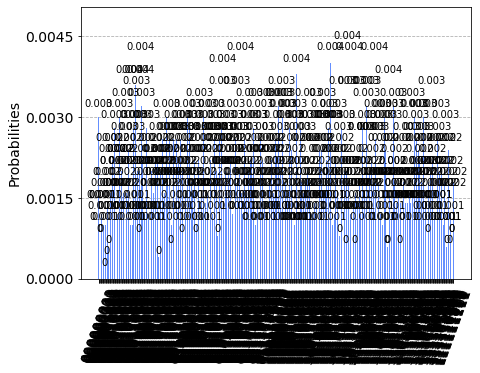

In [5]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram
from qiskit import transpile
from qiskit.visualization import plot_histogram

op, offset = qp.to_ising()

ansatz = QAOAAnsatz(op, reps = 1)  
qc = ansatz.bind_parameters([0.123, 0.432])
qc.measure_all()
qc_trans = transpile(qc,backend)
p = 0.1
job = backend.run(qc_trans, noise_model=get_noise(p,p,p), shots = 5000)
job_monitor(job)
    
counts = job.result().get_counts(qc_trans)
plot_histogram(counts)

Rough Outline:


As we can see, noise can ... However, for systematic errors you can apply error mitigation techniques (mitiq)...


Besides Noise a basic obstacle with arbitrary QUBO formulations is the structure of the energylandscape. Many energylandscapes challenge classical optimizers with local minima in which to get stuck in. ... add energygap, for slow enough evolution... 
As an example, let's have a look at the energylandscape of our formulated QUBO. Due to laptop performance, we can only look have a low resolution precomputed landscape. Nevertheless, it illustrates the ...

In [7]:
#import precomputed energylandscape of QUBO to interact with
import json
data_points = json.load(open("energylandscape_data.txt"))

import pandas as pd
import plotly.graph_objects as go

#create and display surface plot from data_points
df = pd.DataFrame(data_points)
df = df.pivot(index='beta', columns='gamma', values='energy')
matrix = df.to_numpy()
beta_values = df.index.tolist()
gamma_values = df.columns.tolist()

surface_plot = go.Surface(x=gamma_values, y=beta_values,z=matrix, colorscale ='Blues')
fig = go.Figure(data = surface_plot)
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title_text='Energylandscape', scene = dict(
                    xaxis_title='Parameter: gamma',
                    yaxis_title='Parameter: beta',
                    zaxis_title='Energy'),
                    )
fig.show()

### Todo
add plots here and after QAOA  (if there is more you guys want to add to the previous shown ones)


## Outlook (on variational algorithms)

- Warm-start QAOA & other variants
- Error mitigation
- QITE
- Move towards problem-specific algorithms and even hardware